Origionally By Dennis

In [81]:
import os
import csv
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torch.optim.lr_scheduler import ReduceLROnPlateau
%matplotlib inline

In [82]:
train_dir = './Dataset/train'
VAL_SPLIT = 0.2 # let's say we want to use 10% of the dataset for validation
BATCH_SIZE = 32
RESOLUTION = 224

# Define a transform for the training data with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # transforms.Resize((RESOLUTION, RESOLUTION), interpolation=transforms.InterpolationMode.BICUBIC),  # Resize images to a common size
    # transforms.ToTensor(),  # Transform to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

# Define a transform for the validation data without data augmentation
val_transform = transforms.Compose([
    transforms.Resize((RESOLUTION, RESOLUTION), interpolation=transforms.InterpolationMode.BICUBIC),  # Resize images to a common size
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

# Create a dataset for your training data
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

# Determine number of samples for train and validation
num_train = len(full_train_dataset)
num_val = int(VAL_SPLIT * num_train)
num_train -= num_val

# Split the dataset into train and validation sets
train_subset, val_subset = random_split(full_train_dataset, [num_train, num_val])

# Apply transformation to the validation subset
# Re-wrap the dataset so that we can apply the different transformval
val_subset_indices = val_subset.indices
val_subset = datasets.ImageFolder(root=train_dir, transform=val_transform)
val_subset.samples = [full_train_dataset.samples[i] for i in val_subset_indices]

# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False)

# Display training/validation set count
print(f"Training image count: {len(train_subset)}")
print(f"Validation image count: {len(val_subset)}")

Training image count: 864
Validation image count: 215


In [83]:
test_dir = './Dataset/test'

# For the test set, since there are no labels, we need to create a custom DataSet.
class UnlabeledDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super(UnlabeledDataset, self).__init__(root, transform=transform)
        self.images = [os.path.join(root, img) for img in os.listdir(root)]

    def __getitem__(self, index):
        image_path = self.images[index]
        image = datasets.folder.default_loader(image_path)  # default loader is PIL.Image.open
        if self.transform:
            image = self.transform(image)
        return image, str(image_path)

    def __len__(self):
        return len(self.images)

# Create a dataset for your test data
test_dataset = UnlabeledDataset(root=test_dir, transform=val_transform)

# Create a DataLoader for your test set
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [84]:
# Load the pretrained model
# vit_h14 = torch.hub.load("facebookresearch/swag", model="vit_h14")

In [85]:
vit_l16 = torch.hub.load("facebookresearch/swag", model="vit_l16")

Using cache found in C:\Users\Michael/.cache\torch\hub\facebookresearch_swag_main


In [86]:
class ModifiedViT(nn.Module):
    def __init__(self, pretrained_model):
        super(ModifiedViT, self).__init__()
        self.pretrained = pretrained_model
        self.pretrained.head = nn.Identity()  # remove the existing linear layer

        # Freeze all pretrained layers
        for param in self.pretrained.parameters():
            param.requires_grad = False

        self.new_head = nn.Sequential(
            nn.Linear(1024, 100),  # Adjust the input size to match the output size of the ViT model
        )

    def forward(self, x):
        x = self.pretrained(x)
        x = self.new_head(x)
        return x

# Create the modified model
model = ModifiedViT(vit_l16)

In [87]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.new_head.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [88]:
# Send the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 10  # Replace with the number of epochs you want

# Lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            tepoch.set_postfix(loss=(running_loss / (tepoch.n + 1)), accuracy=(correct_predictions / total_predictions))

    # Calculate and print loss and accuracy for the training phase
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Disable gradient calculation for validation to save memory and computations
    with torch.no_grad():
        with tqdm(val_loader, unit="batch") as vepoch:
            for images, labels in vepoch:
                # vepoch.set_description(f"Validation Epoch {epoch+1}/{num_epochs}")

                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                vepoch.set_postfix(val_loss=(val_running_loss / (vepoch.n + 1)), val_accuracy=(val_correct_predictions / val_total_predictions))

    # Calculate and print loss and accuracy for the validation phase
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    # scheduler.step(epoch_loss / len(train_loader))
    # Print summary for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

100%|██████████| 7/7 [00:04<00:00,  1.57batch/s, val_accuracy=0.656, val_loss=45.5]


Epoch [1/10], Train Loss: 3.0137, Train Accuracy: 0.3507, Val Loss: 1.4806, Val Accuracy: 0.6558


100%|██████████| 7/7 [00:04<00:00,  1.60batch/s, val_accuracy=0.767, val_loss=25.3]


Epoch [2/10], Train Loss: 0.9305, Train Accuracy: 0.7616, Val Loss: 0.8251, Val Accuracy: 0.7674


100%|██████████| 7/7 [00:04<00:00,  1.62batch/s, val_accuracy=0.781, val_loss=21.1]


Epoch [3/10], Train Loss: 0.5603, Train Accuracy: 0.8519, Val Loss: 0.6862, Val Accuracy: 0.7814


Epoch 4/10:  81%|████████▏ | 22/27 [00:51<00:11,  2.27s/batch, accuracy=0.876, loss=14.2]

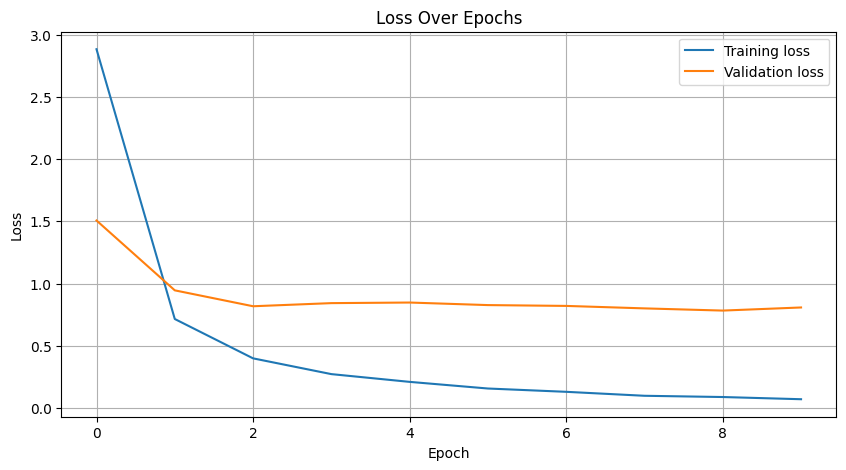

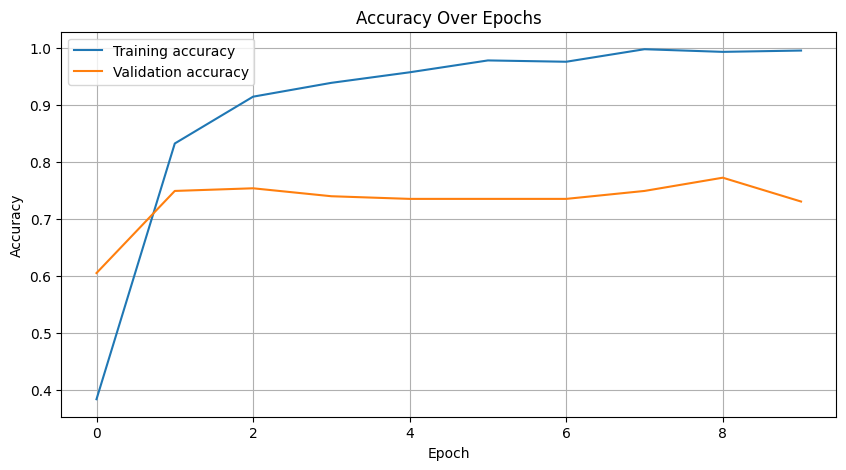

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Model's evaluation mode
model.eval()

test_predictions = []

# Assuming the model is already in evaluation mode and device is defined
with torch.no_grad():
    for images, paths in tqdm(test_loader, desc='Predicting labels'):
        images = images.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels = [full_train_dataset.classes[p] for p in predicted.cpu().numpy()]

        # Go through the batch and add to our prediction list, including image paths
        for path, label in zip(paths, predicted_labels):
            test_predictions.append((Path(path).name, label))  # Appending a tuple of filename and label

with open('ViT_test_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'Label'])
    writer.writerows(test_predictions)  # Writing all predictions at once

Predicting labels: 100%|██████████| 33/33 [00:21<00:00,  1.56it/s]
